## Covid-19 Forecasting (Week 2)
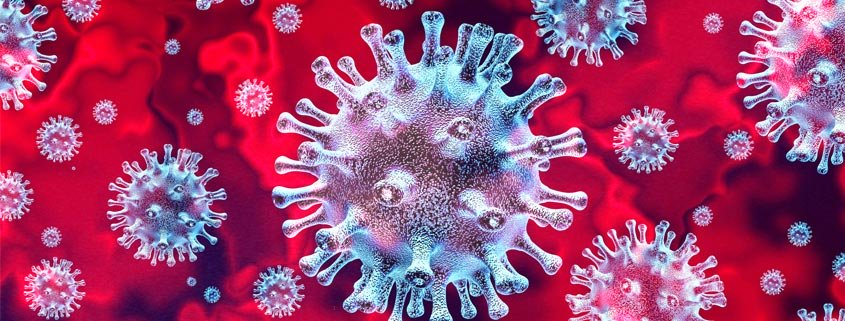

The [covid-19 virus](https://en.wikipedia.org/wiki/Coronavirus_disease_2019) has created a pandemic in the early months of 2020. Kaggle has hosted a series of forecasting competitions for predict the number the spread of the virus. This is my solution for Week 2 of the series.

I am compiling external datasets in the competition format here: https://www.kaggle.com/rohanrao/covid19-forecasting-metadata
They are structured such that it can directly be merged with the train and test datasets on Kaggle.


In [ ]:
## importing packages
import lightgbm as lgb
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")


In [ ]:
## defining constants
PATH_TRAIN = "/kaggle/input/covid19-global-forecasting-week-3/train.csv"
PATH_TEST = "/kaggle/input/covid19-global-forecasting-week-3/test.csv"

PATH_SUBMISSION = "submission.csv"
PATH_OUTPUT = "output.csv"

PATH_REGION_METADATA = "/kaggle/input/covid19-forecasting-metadata/region_metadata.csv"
PATH_REGION_DATE_METADATA = "/kaggle/input/covid19-forecasting-metadata/region_date_metadata.csv"

VAL_DAYS = 7
MAD_FACTOR = 0.5
DAYS_SINCE_CASES = [1, 10, 50, 100, 500, 1000, 5000, 10000]

SEED = 2316

LGB_PARAMS = {"objective": "regression",
              "num_leaves": 5,
              "learning_rate": 0.013,
              "bagging_fraction": 0.91,
              "feature_fraction": 0.81,
              "reg_alpha": 0.13,
              "reg_lambda": 0.13,
              "metric": "rmse",
              "seed": SEED
             }


## Prepare Data
* Unlike many competitions, there are overlapping dates across train and test data. So it is important to be careful while handling the dates.

* Some data issues are fixed using previous max values in case of discrepancy.

* External data from [this dataset](https://www.kaggle.com/rohanrao/covid19-forecasting-metadata) is merged.

In [ ]:
## reading data
train = pd.read_csv(PATH_TRAIN)
test = pd.read_csv(PATH_TEST)

region_metadata = pd.read_csv(PATH_REGION_METADATA)
region_date_metadata = pd.read_csv(PATH_REGION_DATE_METADATA)


In [ ]:
## preparing data
train = train.merge(test[["ForecastId", "Province_State", "Country_Region", "Date"]], on = ["Province_State", "Country_Region", "Date"], how = "left")
test = test[~test.Date.isin(train.Date.unique())]

df_panel = pd.concat([train, test], sort = False)

# combining state and country into 'geography'
df_panel["geography"] = df_panel.Country_Region.astype(str) + ": " + df_panel.Province_State.astype(str)
df_panel.loc[df_panel.Province_State.isna(), "geography"] = df_panel[df_panel.Province_State.isna()].Country_Region

# fixing data issues with cummax
df_panel.ConfirmedCases = df_panel.groupby("geography")["ConfirmedCases"].cummax()
df_panel.Fatalities = df_panel.groupby("geography")["Fatalities"].cummax()

# merging external metadata
df_panel = df_panel.merge(region_metadata, on = ["Country_Region", "Province_State"])
df_panel = df_panel.merge(region_date_metadata, on = ["Country_Region", "Province_State", "Date"], how = "left")

# label encoding continent
df_panel.continent = LabelEncoder().fit_transform(df_panel.continent)
df_panel.Date = pd.to_datetime(df_panel.Date, format = "%Y-%m-%d")

df_panel.sort_values(["geography", "Date"], inplace = True)


## Feature Engineering
* Lag features are created.

* Several differences, ratios and averages of historic values are created and used.

In [ ]:
## feature engineering
min_date_train = np.min(df_panel[~df_panel.Id.isna()].Date)
max_date_train = np.max(df_panel[~df_panel.Id.isna()].Date)

min_date_test = np.min(df_panel[~df_panel.ForecastId.isna()].Date)
max_date_test = np.max(df_panel[~df_panel.ForecastId.isna()].Date)

n_dates_test = len(df_panel[~df_panel.ForecastId.isna()].Date.unique())

print("Train date range:", str(min_date_train), " - ", str(max_date_train))
print("Test date range:", str(min_date_test), " - ", str(max_date_test))

# creating lag features
for lag in range(1, 41):
    df_panel[f"lag_{lag}_cc"] = df_panel.groupby("geography")["ConfirmedCases"].shift(lag)
    df_panel[f"lag_{lag}_ft"] = df_panel.groupby("geography")["Fatalities"].shift(lag)
    df_panel[f"lag_{lag}_rc"] = df_panel.groupby("geography")["Recoveries"].shift(lag)

for case in DAYS_SINCE_CASES:
    df_panel = df_panel.merge(df_panel[df_panel.ConfirmedCases >= case].groupby("geography")["Date"].min().reset_index().rename(columns = {"Date": f"case_{case}_date"}), on = "geography", how = "left")


In [ ]:
## function for preparing features
def prepare_features(df, gap):
    
    df["perc_1_ac"] = (df[f"lag_{gap}_cc"] - df[f"lag_{gap}_ft"] - df[f"lag_{gap}_rc"]) / df[f"lag_{gap}_cc"]
    df["perc_1_cc"] = df[f"lag_{gap}_cc"] / df.population
    
    df["diff_1_cc"] = df[f"lag_{gap}_cc"] - df[f"lag_{gap + 1}_cc"]
    df["diff_2_cc"] = df[f"lag_{gap + 1}_cc"] - df[f"lag_{gap + 2}_cc"]
    df["diff_3_cc"] = df[f"lag_{gap + 2}_cc"] - df[f"lag_{gap + 3}_cc"]
    
    df["diff_1_ft"] = df[f"lag_{gap}_ft"] - df[f"lag_{gap + 1}_ft"]
    df["diff_2_ft"] = df[f"lag_{gap + 1}_ft"] - df[f"lag_{gap + 2}_ft"]
    df["diff_3_ft"] = df[f"lag_{gap + 2}_ft"] - df[f"lag_{gap + 3}_ft"]
    
    df["diff_123_cc"] = (df[f"lag_{gap}_cc"] - df[f"lag_{gap + 3}_cc"]) / 3
    df["diff_123_ft"] = (df[f"lag_{gap}_ft"] - df[f"lag_{gap + 3}_ft"]) / 3

    df["diff_change_1_cc"] = df.diff_1_cc / df.diff_2_cc
    df["diff_change_2_cc"] = df.diff_2_cc / df.diff_3_cc
    
    df["diff_change_1_ft"] = df.diff_1_ft / df.diff_2_ft
    df["diff_change_2_ft"] = df.diff_2_ft / df.diff_3_ft

    df["diff_change_12_cc"] = (df.diff_change_1_cc + df.diff_change_2_cc) / 2
    df["diff_change_12_ft"] = (df.diff_change_1_ft + df.diff_change_2_ft) / 2
    
    df["change_1_cc"] = df[f"lag_{gap}_cc"] / df[f"lag_{gap + 1}_cc"]
    df["change_2_cc"] = df[f"lag_{gap + 1}_cc"] / df[f"lag_{gap + 2}_cc"]
    df["change_3_cc"] = df[f"lag_{gap + 2}_cc"] / df[f"lag_{gap + 3}_cc"]

    df["change_1_ft"] = df[f"lag_{gap}_ft"] / df[f"lag_{gap + 1}_ft"]
    df["change_2_ft"] = df[f"lag_{gap + 1}_ft"] / df[f"lag_{gap + 2}_ft"]
    df["change_3_ft"] = df[f"lag_{gap + 2}_ft"] / df[f"lag_{gap + 3}_ft"]

    df["change_123_cc"] = df[f"lag_{gap}_cc"] / df[f"lag_{gap + 3}_cc"]
    df["change_123_ft"] = df[f"lag_{gap}_ft"] / df[f"lag_{gap + 3}_ft"]
    
    for case in DAYS_SINCE_CASES:
        df[f"days_since_{case}_case"] = (df[f"case_{case}_date"] - df.Date).astype("timedelta64[D]")
        df.loc[df[f"days_since_{case}_case"] < gap, f"days_since_{case}_case"] = np.nan

    df["country_flag"] = df.Province_State.isna().astype(int)
    df["density"] = df.population / df.area
    
    # target variable is log of change from last known value
    df["target_cc"] = np.log1p(df.ConfirmedCases) - np.log1p(df[f"lag_{gap}_cc"])
    df["target_ft"] = np.log1p(df.Fatalities) - np.log1p(df[f"lag_{gap}_ft"])
    
    features = [
        f"lag_{gap}_cc",
        f"lag_{gap}_ft",
        f"lag_{gap}_rc",
        "perc_1_ac",
        "perc_1_cc",
        "diff_1_cc",
        "diff_2_cc",
        "diff_3_cc",
        "diff_1_ft",
        "diff_2_ft",
        "diff_3_ft",
        "diff_123_cc",
        "diff_123_ft",
        "diff_change_1_cc",
        "diff_change_2_cc",
        "diff_change_1_ft",
        "diff_change_2_ft",
        "diff_change_12_cc",
        "diff_change_12_ft",
        "change_1_cc",
        "change_2_cc",
        "change_3_cc",
        "change_1_ft",
        "change_2_ft",
        "change_3_ft",
        "change_123_cc",
        "change_123_ft",
        "days_since_1_case",
        "days_since_10_case",
        "days_since_50_case",
        "days_since_100_case",
        "days_since_500_case",
        "days_since_1000_case",
        "days_since_5000_case",
        "days_since_10000_case",
        "country_flag",
        "lat",
        "lon",
        "continent",
        "population",
        "area",
        "density",
        "target_cc",
        "target_ft"
    ]
    
    return df[features]


## LGB Model
* Note that the target variable used is the change (or difference) in log values of ConfirmedCases / Fatalities from the last known value.

* One model is built for each day in the private test data. So that's a total of 28 models.

* A single set of parameters with less number of leaves along with regularization is used to control overfitting.

In [ ]:
## function for building and predicting using LGBM model
def build_predict_lgbm(df_train, df_test, gap):
    
    df_train.dropna(subset = ["target_cc", "target_ft", f"lag_{gap}_cc", f"lag_{gap}_ft"], inplace = True)
    
    target_cc = df_train.target_cc
    target_ft = df_train.target_ft
    
    test_lag_cc = df_test[f"lag_{gap}_cc"].values
    test_lag_ft = df_test[f"lag_{gap}_ft"].values
    
    df_train.drop(["target_cc", "target_ft"], axis = 1, inplace = True)
    df_test.drop(["target_cc", "target_ft"], axis = 1, inplace = True)
    
    categorical_features = ["continent"]
    
    dtrain_cc = lgb.Dataset(df_train, label = target_cc, categorical_feature = categorical_features)
    dtrain_ft = lgb.Dataset(df_train, label = target_ft, categorical_feature = categorical_features)

    model_cc = lgb.train(LGB_PARAMS, train_set = dtrain_cc, num_boost_round = 200)
    model_ft = lgb.train(LGB_PARAMS, train_set = dtrain_ft, num_boost_round = 200)
    
    # inverse transform from log of change from last known value
    y_pred_cc = np.expm1(model_cc.predict(df_test, num_boost_round = 200) + np.log1p(test_lag_cc))
    y_pred_ft = np.expm1(model_ft.predict(df_test, num_boost_round = 200) + np.log1p(test_lag_ft))
    
    return y_pred_cc, y_pred_ft, model_cc, model_ft


## MAD Model
* This Moving Average with Decay (MAD) model is a simple heuristic using historic values that decays with time.

* It is structured based on my EDA and intuitive feeling of how the Covid-19 trend is likely to move.

In [ ]:
## function for predicting moving average decay model
def predict_mad(df_test, gap, val = False):
    
    df_test["avg_diff_cc"] = (df_test[f"lag_{gap}_cc"] - df_test[f"lag_{gap + 3}_cc"]) / 3
    df_test["avg_diff_ft"] = (df_test[f"lag_{gap}_ft"] - df_test[f"lag_{gap + 3}_ft"]) / 3

    if val:
        y_pred_cc = df_test[f"lag_{gap}_cc"] + gap * df_test.avg_diff_cc - (1 - MAD_FACTOR) * df_test.avg_diff_cc * np.sum([x for x in range(gap)]) / VAL_DAYS
        y_pred_ft = df_test[f"lag_{gap}_ft"] + gap * df_test.avg_diff_ft - (1 - MAD_FACTOR) * df_test.avg_diff_ft * np.sum([x for x in range(gap)]) / VAL_DAYS
    else:
        y_pred_cc = df_test[f"lag_{gap}_cc"] + gap * df_test.avg_diff_cc - (1 - MAD_FACTOR) * df_test.avg_diff_cc * np.sum([x for x in range(gap)]) / n_dates_test
        y_pred_ft = df_test[f"lag_{gap}_ft"] + gap * df_test.avg_diff_ft - (1 - MAD_FACTOR) * df_test.avg_diff_ft * np.sum([x for x in range(gap)]) / n_dates_test

    return y_pred_cc, y_pred_ft


## Modelling
* One model is built for each date.

* For dates already present in train data due to the overlap, no model is built.

* Models are validated using the same framework.

In [ ]:
## building lag x-days models
df_train = df_panel[~df_panel.Id.isna()]
df_test_full = df_panel[~df_panel.ForecastId.isna()]

df_preds_val = []
df_preds_test = []

for date in df_test_full.Date.unique():
    
    print("Processing date:", date)
    
    # ignore date already present in train data
    if date in df_train.Date.values:
        df_pred_test = df_test_full.loc[df_test_full.Date == date, ["ForecastId", "ConfirmedCases", "Fatalities"]].rename(columns = {"ConfirmedCases": "ConfirmedCases_test", "Fatalities": "Fatalities_test"})
        
        # multiplying predictions by 41 to not look cool on public LB
        df_pred_test.ConfirmedCases_test = df_pred_test.ConfirmedCases_test * 41
        df_pred_test.Fatalities_test = df_pred_test.Fatalities_test * 41
    else:
        df_test = df_test_full[df_test_full.Date == date]
        
        gap = (pd.Timestamp(date) - max_date_train).days
        
        if gap <= VAL_DAYS:
            val_date = max_date_train - pd.Timedelta(VAL_DAYS, "D") + pd.Timedelta(gap, "D")

            df_build = df_train[df_train.Date < val_date]
            df_val = df_train[df_train.Date == val_date]
            
            X_build = prepare_features(df_build, gap)
            X_val = prepare_features(df_val, gap)
            
            y_val_cc_lgb, y_val_ft_lgb, _, _ = build_predict_lgbm(X_build, X_val, gap)
            y_val_cc_mad, y_val_ft_mad = predict_mad(df_val, gap, val = True)
            
            df_pred_val = pd.DataFrame({"Id": df_val.Id.values,
                                        "ConfirmedCases_val_lgb": y_val_cc_lgb,
                                        "Fatalities_val_lgb": y_val_ft_lgb,
                                        "ConfirmedCases_val_mad": y_val_cc_mad,
                                        "Fatalities_val_mad": y_val_ft_mad,
                                       })

            df_preds_val.append(df_pred_val)

        X_train = prepare_features(df_train, gap)
        X_test = prepare_features(df_test, gap)

        y_test_cc_lgb, y_test_ft_lgb, model_cc, model_ft = build_predict_lgbm(X_train, X_test, gap)
        y_test_cc_mad, y_test_ft_mad = predict_mad(df_test, gap)
        
        if gap == 1:
            model_1_cc = model_cc
            model_1_ft = model_ft
            features_1 = X_train.columns.values
        elif gap == 14:
            model_14_cc = model_cc
            model_14_ft = model_ft
            features_14 = X_train.columns.values
        elif gap == 28:
            model_28_cc = model_cc
            model_28_ft = model_ft
            features_28 = X_train.columns.values

        df_pred_test = pd.DataFrame({"ForecastId": df_test.ForecastId.values,
                                     "ConfirmedCases_test_lgb": y_test_cc_lgb,
                                     "Fatalities_test_lgb": y_test_ft_lgb,
                                     "ConfirmedCases_test_mad": y_test_cc_mad,
                                     "Fatalities_test_mad": y_test_ft_mad,
                                    })
    
    df_preds_test.append(df_pred_test)


## Validation
* Validating LGB and MAD models using RMSLE metric.

* Visualizing feature importance of 1st, 14th and 28th models to see which features are crucial to predict short-term, medium-term and long-term respectively.

In [ ]:
## validation score
df_panel = df_panel.merge(pd.concat(df_preds_val, sort = False), on = "Id", how = "left")
df_panel = df_panel.merge(pd.concat(df_preds_test, sort = False), on = "ForecastId", how = "left")

rmsle_cc_lgb = np.sqrt(mean_squared_error(np.log1p(df_panel[~df_panel.ConfirmedCases_val_lgb.isna()].ConfirmedCases), np.log1p(df_panel[~df_panel.ConfirmedCases_val_lgb.isna()].ConfirmedCases_val_lgb)))
rmsle_ft_lgb = np.sqrt(mean_squared_error(np.log1p(df_panel[~df_panel.Fatalities_val_lgb.isna()].Fatalities), np.log1p(df_panel[~df_panel.Fatalities_val_lgb.isna()].Fatalities_val_lgb)))

rmsle_cc_mad = np.sqrt(mean_squared_error(np.log1p(df_panel[~df_panel.ConfirmedCases_val_mad.isna()].ConfirmedCases), np.log1p(df_panel[~df_panel.ConfirmedCases_val_mad.isna()].ConfirmedCases_val_mad)))
rmsle_ft_mad = np.sqrt(mean_squared_error(np.log1p(df_panel[~df_panel.Fatalities_val_mad.isna()].Fatalities), np.log1p(df_panel[~df_panel.Fatalities_val_mad.isna()].Fatalities_val_mad)))

print("LGB CC RMSLE Val of", VAL_DAYS, "days for CC:", round(rmsle_cc_lgb, 2))
print("LGB FT RMSLE Val of", VAL_DAYS, "days for FT:", round(rmsle_ft_lgb, 2))
print("LGB Overall RMSLE Val of", VAL_DAYS, "days:", round((rmsle_cc_lgb + rmsle_ft_lgb) / 2, 2))
print("\n")
print("MAD CC RMSLE Val of", VAL_DAYS, "days for CC:", round(rmsle_cc_mad, 2))
print("MAD FT RMSLE Val of", VAL_DAYS, "days for FT:", round(rmsle_ft_mad, 2))
print("MAD Overall RMSLE Val of", VAL_DAYS, "days:", round((rmsle_cc_mad + rmsle_ft_mad) / 2, 2))


In [ ]:
## feature importance
from bokeh.io import output_notebook, show
from bokeh.layouts import column
from bokeh.palettes import Spectral3
from bokeh.plotting import figure

output_notebook()

df_fimp_1_cc = pd.DataFrame({"feature": features_1, "importance": model_1_cc.feature_importance(), "model": "m01"})
df_fimp_14_cc = pd.DataFrame({"feature": features_14, "importance": model_14_cc.feature_importance(), "model": "m14"})
df_fimp_28_cc = pd.DataFrame({"feature": features_28, "importance": model_28_cc.feature_importance(), "model": "m28"})

df_fimp_1_cc.sort_values("importance", ascending = False, inplace = True)
df_fimp_14_cc.sort_values("importance", ascending = False, inplace = True)
df_fimp_28_cc.sort_values("importance", ascending = False, inplace = True)

v1 = figure(plot_width = 800, plot_height = 400, x_range = df_fimp_1_cc.feature, title = "Feature Importance of LGB Model 1")
v1.vbar(x = df_fimp_1_cc.feature, top = df_fimp_1_cc.importance, width = 1)
v1.xaxis.major_label_orientation = 1.3

v14 = figure(plot_width = 800, plot_height = 400, x_range = df_fimp_14_cc.feature, title = "Feature Importance of LGB Model 14")
v14.vbar(x = df_fimp_14_cc.feature, top = df_fimp_14_cc.importance, width = 1)
v14.xaxis.major_label_orientation = 1.3

v28 = figure(plot_width = 800, plot_height = 400, x_range = df_fimp_28_cc.feature, title = "Feature Importance of LGB Model 28")
v28.vbar(x = df_fimp_28_cc.feature, top = df_fimp_28_cc.importance, width = 1)
v28.xaxis.major_label_orientation = 1.3

v = column(v1, v14, v28)

show(v)


## Visualizing Predictions
* Viewing the actual, validation and test values together for each geography for ConfirmedCases as well as Fatalities.

In [ ]:
## visualizing ConfirmedCases
from bokeh.models import Panel, Tabs
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()

tab_list = []

for geography in df_panel.geography.unique():
    df_geography = df_panel[df_panel.geography == geography]
    v = figure(plot_width = 800, plot_height = 400, x_axis_type = "datetime", title = "Covid-19 ConfirmedCases over time")
    v.line(df_geography.Date, df_geography.ConfirmedCases, color = "green", legend_label = "CC (Train)")
    v.line(df_geography.Date, df_geography.ConfirmedCases_val_lgb, color = "blue", legend_label = "CC LGB (Val)")
    v.line(df_geography.Date, df_geography.ConfirmedCases_val_mad, color = "purple", legend_label = "CC MAD (Val)")
    v.line(df_geography.Date[df_geography.Date > max_date_train], df_geography.ConfirmedCases_test_lgb[df_geography.Date > max_date_train], color = "red", legend_label = "CC LGB (Test)")
    v.line(df_geography.Date[df_geography.Date > max_date_train], df_geography.ConfirmedCases_test_mad[df_geography.Date > max_date_train], color = "orange", legend_label = "CC MAD (Test)")
    v.legend.location = "top_left"
    tab = Panel(child = v, title = geography)
    tab_list.append(tab)

tabs = Tabs(tabs=tab_list)
show(tabs)


In [ ]:
## visualizing Fatalities
from bokeh.models import Panel, Tabs
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()

tab_list = []

for geography in df_panel.geography.unique():
    df_geography = df_panel[df_panel.geography == geography]
    v = figure(plot_width = 800, plot_height = 400, x_axis_type = "datetime", title = "Covid-19 Fatalities over time")
    v.line(df_geography.Date, df_geography.Fatalities, color = "green", legend_label = "FT (Train)")
    v.line(df_geography.Date, df_geography.Fatalities_val_lgb, color = "blue", legend_label = "FT LGB (Val)")
    v.line(df_geography.Date, df_geography.Fatalities_val_mad, color = "purple", legend_label = "FT MAD (Val)")
    v.line(df_geography.Date[df_geography.Date > max_date_train], df_geography.Fatalities_test_lgb[df_geography.Date > max_date_train], color = "red", legend_label = "FT LGB (Test)")
    v.line(df_geography.Date[df_geography.Date > max_date_train], df_geography.Fatalities_test_mad[df_geography.Date > max_date_train], color = "orange", legend_label = "FT MAD (Test)")
    v.legend.location = "top_left"
    tab = Panel(child = v, title = geography)
    tab_list.append(tab)

tabs = Tabs(tabs=tab_list)
show(tabs)


## Submission
* Combining the two aapproaches using weights for final submission.

* LGB models don't seem to perform well for certain geographies and are replaced by MAD predictions.

In [ ]:
## preparing submission file
df_test = df_panel.loc[~df_panel.ForecastId.isna(), ["ForecastId", "Country_Region", "Province_State", "Date",
                                                     "ConfirmedCases_test", "ConfirmedCases_test_lgb", "ConfirmedCases_test_mad",
                                                     "Fatalities_test", "Fatalities_test_lgb", "Fatalities_test_mad"]].reset_index()

df_test["ConfirmedCases"] = 0.41 * df_test.ConfirmedCases_test_lgb + 0.59 * df_test.ConfirmedCases_test_mad
df_test["Fatalities"] = 0.05 * df_test.Fatalities_test_lgb + 0.95 * df_test.Fatalities_test_mad

# Since LGB models don't predict these countries well
df_test.loc[df_test.Country_Region.isin(["China", "US", "Diamond Princess"]), "ConfirmedCases"] = df_test[df_test.Country_Region.isin(["China", "US", "Diamond Princess"])].ConfirmedCases_test_mad.values
df_test.loc[df_test.Country_Region.isin(["China", "US", "Diamond Princess"]), "Fatalities"] = df_test[df_test.Country_Region.isin(["China", "US", "Diamond Princess"])].Fatalities_test_mad.values

df_test.loc[df_test.Date.isin(df_train.Date.values), "ConfirmedCases"] = df_test[df_test.Date.isin(df_train.Date.values)].ConfirmedCases_test.values
df_test.loc[df_test.Date.isin(df_train.Date.values), "Fatalities"] = df_test[df_test.Date.isin(df_train.Date.values)].Fatalities_test.values

df_submission = df_test[["ForecastId", "ConfirmedCases", "Fatalities"]]
df_submission.ForecastId = df_submission.ForecastId.astype(int)

df_submission


In [ ]:
## writing final submission and complete output
df_submission.to_csv(PATH_SUBMISSION, index = False)
df_test.to_csv(PATH_OUTPUT, index = False)
